In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

## Load data

In [2]:
TRAINING_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
TRAINING_LABELS_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
x_train = pd.read_csv(TRAINING_DATA_URL, index_col='id')
y_train = pd.read_csv(TRAINING_LABELS_URL, index_col='id')
df_train = x_train.merge(y_train, on='id')
df_train.shape

(59400, 40)

## Remove single observation from 2002

In [3]:
df_train = df_train.drop(14428, errors='ignore')
df_train.shape

(59399, 40)

## Fill missing data

In [4]:
def fill_missing_geo(row):
  if(row.longitude == 0):
    result = df_train[(df_train['region']==row.region) & (df_train['longitude']!=0)].longitude.mean()
    row.longitude= result
  
  if(row.latitude == -2e-8):
    result = df_train[(df_train['region']==row.region) & (df_train['latitude']!=-2e-8)].latitude.mean()
    row.latitude= result
  
  return row

In [5]:
df_train = df_train.apply(lambda x: fill_missing_geo(x), axis=1)

## Observation date - new features

In [6]:
df_train['month_recorded'] = df_train['date_recorded'].map(lambda x: x.split('-')[1])
df_train['day_recorded'] = df_train['date_recorded'].map(lambda x: x.split('-')[2])

## Fill NA values
Can be improved only if feature has high importance!

In [7]:
df_train.permit = df_train.permit.fillna(False)
df_train.scheme_management = df_train.scheme_management.fillna('Other')

## Boolean columns to int 0/1

In [8]:
df_train['public_meeting'] = df_train['public_meeting'].apply(lambda x : 1 if x==True else 0)
df_train['permit'] = df_train['permit'].apply(lambda x : 1 if x==True else 0)

## Select features

In [11]:
CONTINOUS_VALUE_COLUMNS = ['longitude', 'latitude','month_recorded','day_recorded']
DATE_COLUMNS = []
ORDINAL_VALUE_COLUMNS = []
NOMINAL_VALUE_COLUMNS = [ 'basin','region', 'district_code','scheme_management', #'installer',
                         'extraction_type_class', 'payment',  'quantity','source_class', 'waterpoint_type']
BOOLEAN_VALUE_COLUMNS = ['permit', 'public_meeting']
TARGET_COLUMN = 'status_group'

len(CONTINOUS_VALUE_COLUMNS)+len(DATE_COLUMNS)+len(ORDINAL_VALUE_COLUMNS)+len(NOMINAL_VALUE_COLUMNS)+len(BOOLEAN_VALUE_COLUMNS)

15

In [12]:
filtered_df_train = df_train[CONTINOUS_VALUE_COLUMNS + DATE_COLUMNS + ORDINAL_VALUE_COLUMNS + NOMINAL_VALUE_COLUMNS+BOOLEAN_VALUE_COLUMNS+[TARGET_COLUMN]]
filtered_df_train.head()

,longitude,latitude,month_recorded,day_recorded,basin,region,district_code,scheme_management,extraction_type_class,payment,quantity,source_class,waterpoint_type,permit,public_meeting,status_group
id,,,,,,,,,,,,,,,,
69572,34.938093,-9.856322,03,14,Lake Nyasa,Iringa,5,VWC,gravity,pay annually,enough,groundwater,communal standpipe,0,1,functional
8776,34.698766,-2.147466,03,06,Lake Victoria,Mara,2,Other,gravity,never pay,insufficient,surface,communal standpipe,1,0,functional
34310,37.460664,-3.821329,02,25,Pangani,Manyara,4,VWC,gravity,pay per bucket,enough,surface,communal standpipe multiple,1,1,functional
67743,38.486161,-11.155298,01,28,Ruvuma / Southern Coast,Mtwara,63,VWC,submersible,never pay,dry,groundwater,communal standpipe multiple,1,1,non functional
19728,31.130847,-1.825359,07,13,Lake Victoria,Kagera,1,Other,gravity,never pay,seasonal,surface,communal standpipe,1,1,functional


In [17]:
filtered_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59399 entries, 69572 to 26348
Data columns (total 16 columns):
longitude                59399 non-null float64
latitude                 59399 non-null float64
month_recorded           59399 non-null object
day_recorded             59399 non-null object
basin                    59399 non-null object
region                   59399 non-null object
district_code            59399 non-null int64
scheme_management        59399 non-null object
extraction_type_class    59399 non-null object
payment                  59399 non-null object
quantity                 59399 non-null object
source_class             59399 non-null object
waterpoint_type          59399 non-null object
permit                   59399 non-null int64
public_meeting           59399 non-null int64
status_group             59399 non-null object
dtypes: float64(2), int64(3), object(11)
memory usage: 7.7+ MB


## Encode & Transform

In [18]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
result = encoder.fit_transform(filtered_df_train[NOMINAL_VALUE_COLUMNS])
encoder.get_feature_names()

array(['x0_Internal', 'x0_Lake Nyasa', 'x0_Lake Rukwa',
       'x0_Lake Tanganyika', 'x0_Lake Victoria', 'x0_Pangani',
       'x0_Rufiji', 'x0_Ruvuma / Southern Coast', 'x0_Wami / Ruvu',
       'x1_Arusha', 'x1_Dar es Salaam', 'x1_Dodoma', 'x1_Iringa',
       'x1_Kagera', 'x1_Kigoma', 'x1_Kilimanjaro', 'x1_Lindi',
       'x1_Manyara', 'x1_Mara', 'x1_Mbeya', 'x1_Morogoro', 'x1_Mtwara',
       'x1_Mwanza', 'x1_Pwani', 'x1_Rukwa', 'x1_Ruvuma', 'x1_Shinyanga',
       'x1_Singida', 'x1_Tabora', 'x1_Tanga', 'x2_0', 'x2_1', 'x2_2',
       'x2_3', 'x2_4', 'x2_5', 'x2_6', 'x2_7', 'x2_8', 'x2_13', 'x2_23',
       'x2_30', 'x2_33', 'x2_43', 'x2_53', 'x2_60', 'x2_62', 'x2_63',
       'x2_67', 'x2_80', 'x3_Company', 'x3_None', 'x3_Other',
       'x3_Parastatal', 'x3_Private operator', 'x3_SWC', 'x3_Trust',
       'x3_VWC', 'x3_WUA', 'x3_WUG', 'x3_Water Board',
       'x3_Water authority', 'x4_gravity', 'x4_handpump', 'x4_motorpump',
       'x4_other', 'x4_rope pump', 'x4_submersible', 'x4_wind-powe

In [19]:
from sklearn.preprocessing import OrdinalEncoder
target_enc = OrdinalEncoder()
target_result = target_enc.fit_transform(filtered_df_train[TARGET_COLUMN].values.reshape(-1,1))
target_enc.categories_

[array(['functional', 'functional needs repair', 'non functional'],
       dtype=object)]

In [20]:
from sklearn.preprocessing import PowerTransformer
p_trans = PowerTransformer()
continous_values_transformed = p_trans.fit_transform(filtered_df_train[CONTINOUS_VALUE_COLUMNS])

In [21]:
output_cols = CONTINOUS_VALUE_COLUMNS.copy()
output_cols.extend(BOOLEAN_VALUE_COLUMNS.copy())
output_cols.extend(encoder.get_feature_names())
output_cols.append('target')
output_data = np.copy(result)
output_data = np.concatenate((continous_values_transformed, filtered_df_train[BOOLEAN_VALUE_COLUMNS], result, target_result),axis =1)
output_cols
df_output = pd.DataFrame(output_data, columns=output_cols)
df_output.head()

,longitude,latitude,month_recorded,day_recorded,permit,public_meeting,x0_Internal,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x7_surface,x7_unknown,x8_cattle trough,x8_communal standpipe,x8_communal standpipe multiple,x8_dam,x8_hand pump,x8_improved spring,x8_other,target
0,-0.072579,-1.333935,-0.203651,-0.113275,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.164850,1.467179,-0.203651,-1.095515,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.914459,0.624939,-0.800019,1.052948,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.323128,-1.649368,-1.737012,1.349163,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
4,-1.511151,1.662763,1.031072,-0.227724,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Oversample

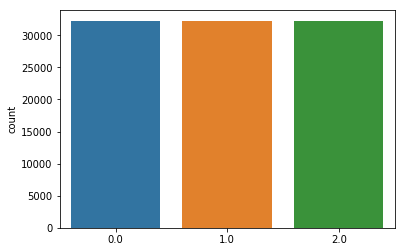

In [22]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42, k_neighbors=5)
x_over_sampled, y_over_sampled = over_sampling.fit_resample(df_output.drop('target', axis=1), df_output.target)
sns.countplot(x=y_over_sampled);

In [23]:
df_oversampled = pd.DataFrame(np.column_stack((x_over_sampled, y_over_sampled)), columns=df_output.columns)

## XGBoost

In [25]:
x = df_oversampled.drop('target', axis=1)
y = df_oversampled.target

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

params_model1 = {
    'booster': ['gbtree', 'dart'],
    'n_estimators': [100, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1,5,10],
    'gamma': [0, 0.5, 1, 2],
    'colsample_bytree': [0.8, 1.0],
    'max_depth': [4, 5, 7],
    'max_delta_step': [0, 1, 2,3],
    'base_score': [0.4, 0.5,  0.6],
    'reg_alpha':[0, 0.8],
    'reg_lambda': [0, 0.8],
}

model1 = XGBClassifier(n_estimators=100, learning_rate=0.01, subsample=0.8, objective='multi:softprob', num_class=3,
                      gamma=0, max_depth=4, colsample_bytree=1)
rs_model1 = RandomizedSearchCV(model1, param_distributions=params_model1, n_iter=3, refit='accuracy',
                               scoring='accuracy', n_jobs=3, cv=skf.split(x,y), verbose=3, random_state=1001 )

rs_model1.fit(x,y)

rs_model1.best_score_, rs_model1.best_params_ 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


## AutoML

In [ ]:
! apt-get install default-jre
! java -version
! pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
h2o_data = h2o.H2OFrame(df_oversampled)
target_idx = h2o_data.col_names.index('target')
h2o_data[target_idx] = h2o_data[target_idx].asfactor()
aml = H2OAutoML(max_models = 10, seed = 1, max_runtime_secs=500000, nfolds=3, include_algos = ["XGBoost"])
aml.train(y = 'target', training_frame = h2o_data)

In [ ]:
aml.leaderboard

In [ ]:
aml_leader = aml.leader
aml_leader.confusion_matrix(h2o_data)